# Decision Trees and Random Forests

## Introduction
In the previous notebook, we prepared the data and trained a logistic regression model. In this section we will use decision trees and random forest models and perform basic hyperparameter tuning. This helps derive basic insights into how the model classifies based on the data and gain useful insights into our restaurants dataset.

### Importing modules

In [1]:
import joblib
import pyarrow

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import plot_tree, export_text
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix 
from sklearn.metrics import precision_score, recall_score, classification_report, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# to display all columns
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Importing the prepared datasets
We read in the training, validation and test sets from our previous notebook using the `parquet` library. We then import the logistic regerssion model using `joblib` to verify the data.

In [5]:
%%time

train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')
val_targets = pd.read_parquet('val_targets.parquet')
test_targets = pd.read_parquet('test_targets.parquet')

Wall time: 40.4 ms


In [6]:
Tampa_restaurants1 = joblib.load('Tampa_restaurants.joblib')

In [7]:
# sanity check
test_preds2 = Tampa_restaurants1['model'].predict(test_inputs)
accuracy_score(test_targets, test_preds2)

0.8093587521663779

## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Training

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
model = DecisionTreeClassifier(random_state=42)

In [10]:
%%time
model.fit(train_inputs, train_targets)

Wall time: 19.9 ms


DecisionTreeClassifier(random_state=42)

An optimal decision tree has now been created using the training data.

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [12]:
train_preds = model.predict(train_inputs)

In [13]:
train_preds

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [14]:
pd.value_counts(train_preds)

1    1213
0     630
dtype: int64

The decision tree also returns probabilities for each prediction.

In [15]:
train_probs = model.predict_proba(train_inputs)

In [16]:
train_probs

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [17]:
accuracy_score(train_targets, train_preds)

1.0

The training set accuracy is close to 100%, but we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [18]:
model.score(val_inputs, val_targets)

0.6984815618221258

### Visualization

We can visualize the decision tree _learned_ from the training data.

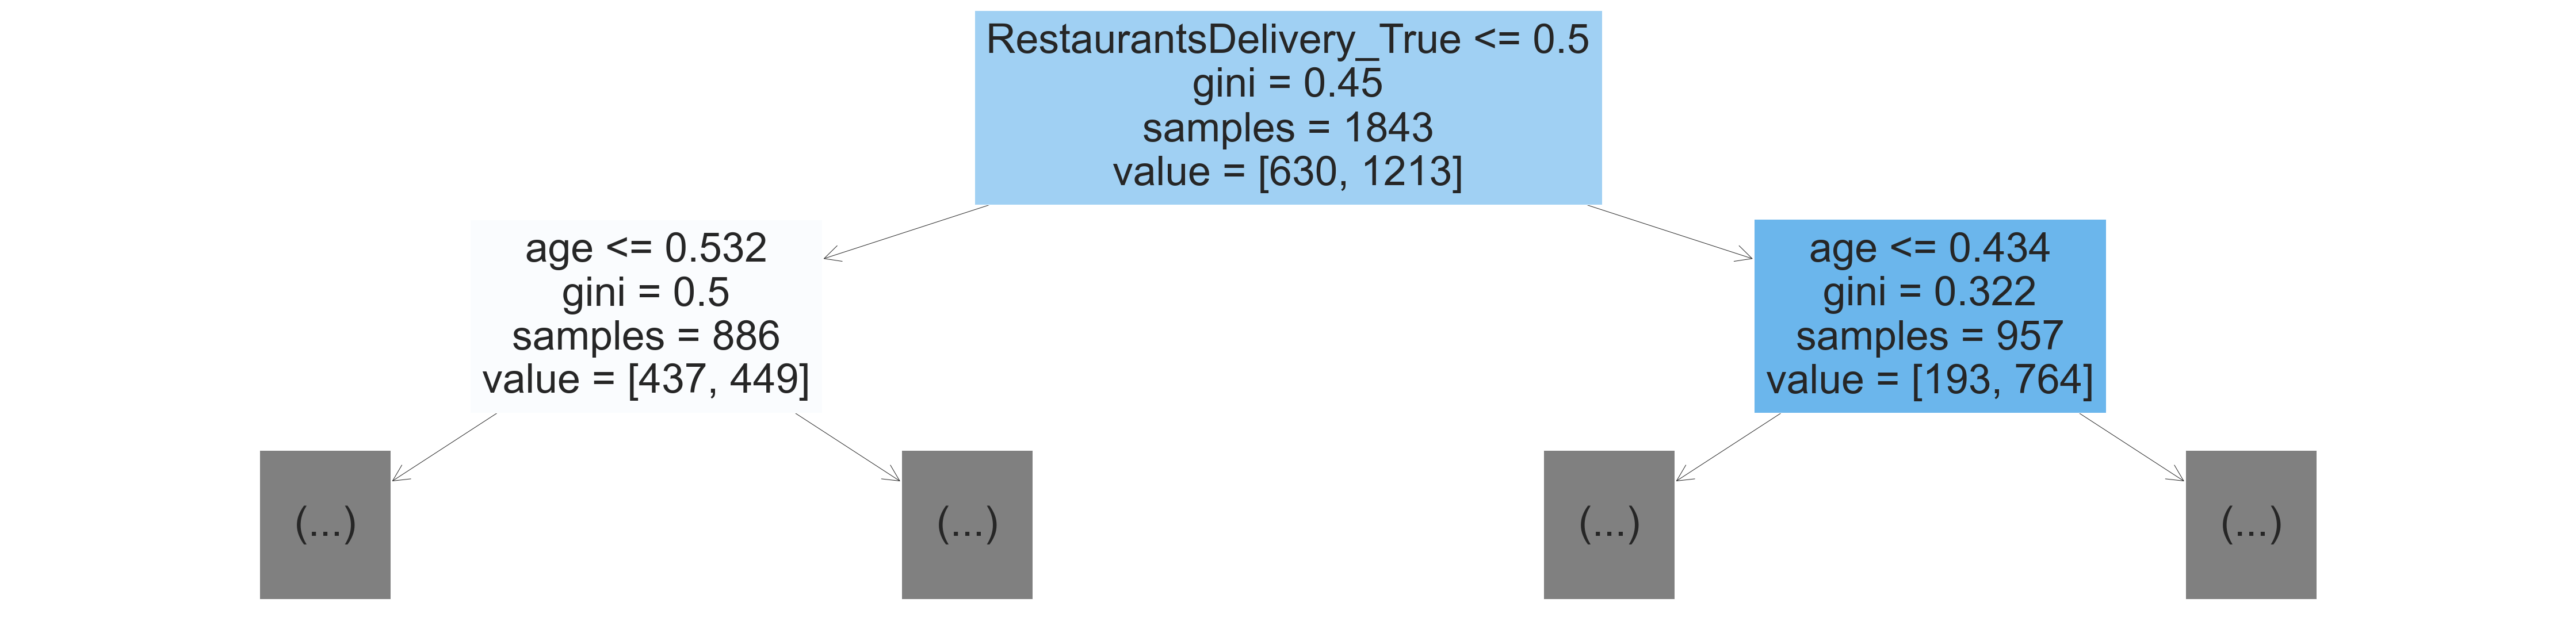

In [19]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=train_inputs.columns, max_depth=1, filled=True);

How a Decision Tree is Created

Note the gini value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0.

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:


Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

In [20]:
model.tree_.max_depth

19

We can also display the tree as text, which can be easier to follow for deeper trees.

In [21]:
tree_text = export_text(model, max_depth=10, feature_names=list(train_inputs.columns))
print(tree_text[:5000])

|--- RestaurantsDelivery_True <= 0.50
|   |--- age <= 0.53
|   |   |--- RestaurantsGoodForGroups_True <= 0.50
|   |   |   |--- age <= 0.06
|   |   |   |   |--- Num_of_attributes_shared <= 0.58
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Num_of_attributes_shared >  0.58
|   |   |   |   |   |--- class: 0
|   |   |   |--- age >  0.06
|   |   |   |   |--- relative_reviews_count <= 0.07
|   |   |   |   |   |--- similar_restaurants_density <= 0.04
|   |   |   |   |   |   |--- RestaurantsGoodForGroups_False <= 0.50
|   |   |   |   |   |   |   |--- sentiment_score <= 0.87
|   |   |   |   |   |   |   |   |--- reactions_per_week <= 0.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- reactions_per_week >  0.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- sentiment_score >  0.87
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- RestaurantsGoodForGroups_False >  0.50
|   |   |   |   |  

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [22]:
model.feature_importances_

array([0.01126244, 0.04656014, 0.00180878, 0.00351211, 0.00360507,
       0.09431669, 0.        , 0.0131122 , 0.01672856, 0.00064268,
       0.0075958 , 0.03971584, 0.00215873, 0.02424549, 0.00200975,
       0.        , 0.00530575, 0.00034586, 0.0016413 , 0.        ,
       0.        , 0.        , 0.00386421, 0.00373814, 0.00536664,
       0.00330242, 0.00497188, 0.00075058, 0.        , 0.00231524,
       0.00067012, 0.        , 0.00427609, 0.00446961, 0.00057996,
       0.        , 0.0016078 , 0.00304344, 0.        , 0.        ,
       0.01642195, 0.16543872, 0.03515722, 0.03021404, 0.04235859,
       0.08627445, 0.02535592, 0.03145207, 0.04517261, 0.06577828,
       0.04326074, 0.03266181, 0.03006646, 0.03686383])

Let's turn this into a dataframe and visualize the most important features.

In [23]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

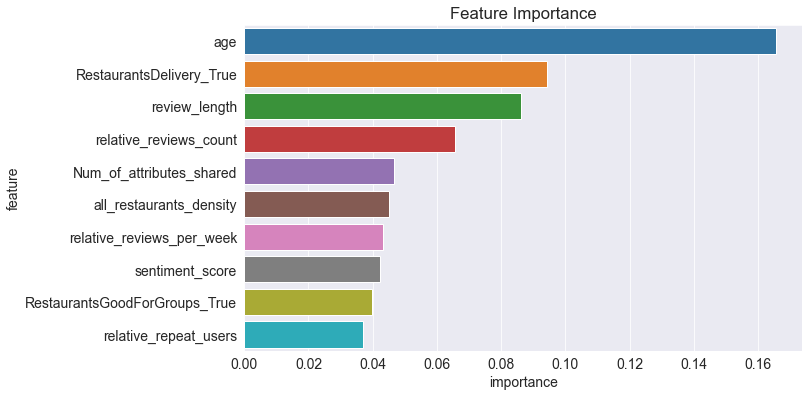

In [24]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as _regularlization_.


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

Let's use a helper funtion to change th depth parameter of the decision tree and improve performance

In [25]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [26]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

Wall time: 329 ms


In [27]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.341834,0.340564
1,2,0.286489,0.318872
2,3,0.255562,0.290672
3,4,0.211612,0.281996
4,5,0.193163,0.284165
5,6,0.170374,0.292842
6,7,0.129680,0.264642
7,8,0.100380,0.292842
8,9,0.068909,0.288503
9,10,0.040152,0.277657


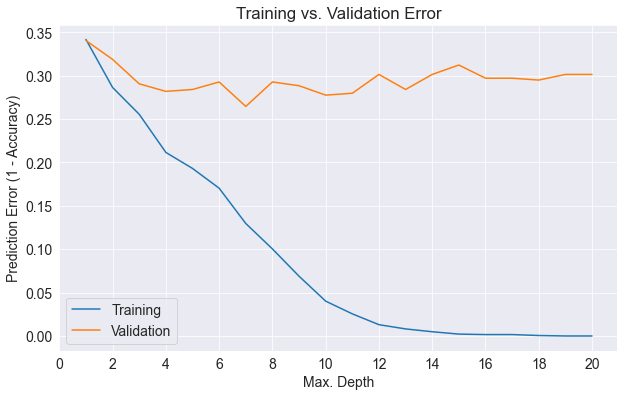

In [28]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">




We can tune this hyperparameter to find the optimal fit. We see that a maximum depth of 7 results in the lowest validation error. However, Since there is a significant gain in training accuracy until depth 12, we will chose this to be our model hyperparamter. The validation set loss increase by 4 % in this case.

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [29]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [30]:
model.fit(train_inputs, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [31]:
model.score(train_inputs, train_targets)

0.9424850786760717

In [32]:
model.score(val_inputs, val_targets)

0.735357917570499

In [33]:
model.tree_.max_depth

13

Notice that the model was able to achieve a greater depth of 13 for certain paths while keeping other paths shorter.

In [34]:
model_text = export_text(model, feature_names=list(train_inputs.columns))
print(model_text[:3000])

|--- RestaurantsDelivery_True <= 0.50
|   |--- age <= 0.53
|   |   |--- RestaurantsGoodForGroups_True <= 0.50
|   |   |   |--- age <= 0.06
|   |   |   |   |--- Num_of_attributes_shared <= 0.58
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Num_of_attributes_shared >  0.58
|   |   |   |   |   |--- class: 0
|   |   |   |--- age >  0.06
|   |   |   |   |--- relative_reviews_count <= 0.07
|   |   |   |   |   |--- similar_restaurants_density <= 0.04
|   |   |   |   |   |   |--- RestaurantsGoodForGroups_False <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- RestaurantsGoodForGroups_False >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- similar_restaurants_density >  0.04
|   |   |   |   |   |   |--- relative_reviews_per_week <= 0.05
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- relative_reviews_per_week >  0.05
|   |   |   |   |   |   |   |--- age <= 0.08
|   |   |   |   |   |   |   |   |--- class: 1
|  

We will later use gridsearch to optimize paramters and find the best model. However, we already see some important features that are relevant in predicting a restaurants sustainability and how the model interprets them. This is a powerful feature of using decision trees and random forests, which we train in the following section.

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. Thus, a random forest works by averaging/combining the results of several decision trees:





<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [37]:
%%time
model.fit(train_inputs, train_targets)

Wall time: 101 ms


RandomForestClassifier(n_jobs=-1, random_state=42)

In [38]:
model.score(train_inputs, train_targets)

1.0

In [39]:
model.score(val_inputs, val_targets)

0.7874186550976139

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far.

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [40]:
train_probs = model.predict_proba(train_inputs)
train_probs

array([[0.02, 0.98],
       [0.03, 0.97],
       [0.09, 0.91],
       ...,
       [0.06, 0.94],
       [0.31, 0.69],
       [0.71, 0.29]])

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [41]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [42]:
importance_df.head(10)

,feature,importance
41,age,0.105174
45,review_length,0.077070
49,relative_reviews_count,0.065209
1,Num_of_attributes_shared,0.049493
52,relative_user_stars,0.047511
53,relative_repeat_users,0.046053
44,sentiment_score,0.045463
42,reviews_per_week,0.043532
51,relative_stars,0.043474
50,relative_reviews_per_week,0.042670


In [43]:
importance_df.tail(10)

,feature,importance
32,Latin American,0.002806
36,Delis,0.002689
33,Food Trucks,0.002648
28,Italian,0.002640
29,Chicken Wings,0.002458
27,Seafood,0.002420
34,Specialty Food,0.002400
39,Caterers,0.001955
38,Desserts,0.001764
37,Sushi Bars,0.001754


In [44]:
# add top 10 features in df for open and closed category
df_open = importance_df.sort_values(by='importance', ascending=False).head(15)
df_close = importance_df.sort_values(by='importance', ascending=True).head(15)
coef_imp = pd.concat([df_open, df_close], axis=0)

In [45]:
coef_imp['importance'] = coef_imp['importance'] - 0.02

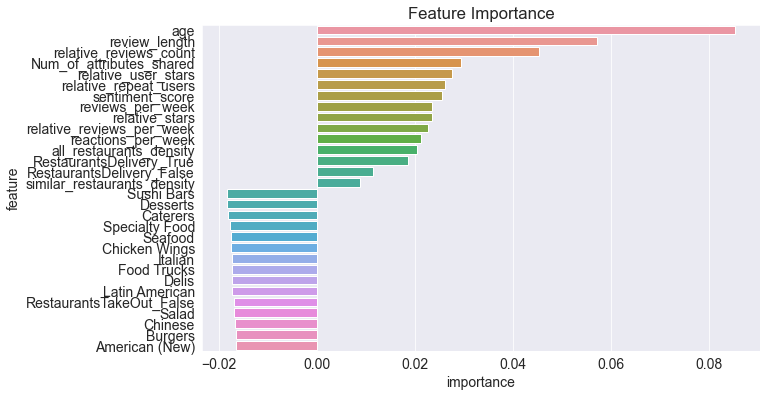

In [46]:
plt.title('Feature Importance')
sns.barplot(data=coef_imp, x='importance', y='feature');


Primary features in predicting if a restaurant will remain open in the future are: 
1. Age: It provides information about how old is the restaurant
2. Review length: Longer the review length, which is usually the case with bad reviews, the higher the chances for the restaurant running out of business in the future.
2. Number of attributes shared: There are a total of 35 attributes that are listed on yelp for restaurants. The most successful restaurants share majorly all of attributes, which correspond to the services available at that restaurant.
3. Relative Reviews Count: This field provides information about how many reviews are received by a restaurant as compared to it's neighbors within 1 km radius.

For features such as Outdoor seating, RestaurantsGoodForGroups and GoodForKids features, it seems that these do not directly correlate to a restaurant's future as irrespective of true value or a false value, the restaurant was closed.

We also see some categories such as American (New), Burgers and Chinese food are more likely to close.

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Let's create a base model with which we can compare models with tuned hyperparameters.

In [47]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(train_inputs, train_targets)

In [48]:
base_train_acc = base_model.score(train_inputs, train_targets)
base_val_acc = base_model.score(val_inputs, val_targets)

In [49]:
base_accs = base_train_acc, base_val_acc
base_accs

(1.0, 0.7874186550976139)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [50]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [51]:
model.fit(train_inputs, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [52]:
model.score(train_inputs, train_targets), model.score(val_inputs, val_targets)

(0.9918610960390667, 0.7288503253796096)

In [53]:
base_accs

(1.0, 0.7874186550976139)

**500 estimators**

In [54]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(train_inputs, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [55]:
model.score(train_inputs, train_targets)

1.0

In [56]:
model.score(val_inputs, val_targets)

0.7809110629067245

In [57]:
base_accs

(1.0, 0.7874186550976139)

We see that the validation score increased by 6% when we increased the number of estimators. We could also check other paramters like `maximum leaf nodes` to tweak the model's performance on this dataset. In this notebook, we saw some important features determining the sustainability of a restaurant and how our models predicts based on those features. This visualization is unique to decision trees and helps derive some basic insights into our restaurant dataset. In the following notebook, we can implement more rigorous and robust tools to analyze the model's performance and optimize the model parameters using `GridSearch`.